# Sum-Kbody-CNN Tutorial

* Author: Xin Chen
* Email: Bismarrck@me.com

A short tutorial of how to use a trained `sum-kbody-cnn` model to make predictions and some basic performance analysis.

## 1. Tutorial

The first part of this notebooke is a tutorial demonstrating how to use `CNNPredictor` and a trained meta-model to make predictions.

In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
%aimport kbody_visualize

import numpy as np
import sys
import time
import seaborn as sns
from matplotlib import pyplot as plt
from kbody_predict import CNNPredictor
from kbody_input import extract_xyz, SEED
from os.path import join
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


One of the test example of $\textrm{C}_9\textrm{H}_7\textrm{N}$:

**Note:** 

1. The unit of the predicted energies is eV.
2. The atomic coordinates should be stored in a 3D numpy array of shape `[num_examples, num_atoms, 3]`.
3. The `species` should a list of strings and `len(species)` should be `num_atoms` but not `num_atoms * num_examples`.

In [2]:
example = {
  "coords": np.array([
    [13.64290653,      14.13624462,       5.00000000],
    [14.15947101,      10.84962323,       5.00000000],
    [14.76810787,       9.57195729,       5.00000000],
    [15.48133668,       8.52875020,       5.00000000],
    [12.43268116,      13.68893092,       5.00000000],
    [12.80400662,      11.04896203,       5.00000000],
    [10.69871088,      11.93562620,       5.00000000],
    [10.49418002,      10.46513468,       5.00000000],
    [11.80136861,       9.98973463,       5.00000000],
    [12.02985377,      12.30192209,       5.00000000],
    [13.81935751,      15.13241536,       5.00000000],
    [14.45192832,      13.52872145,       5.00000000],
    [14.86239638,      11.67891117,       5.00000000],
    [11.63193585,      14.42890524,       5.00000000],
    [ 9.87504964,      12.64680696,       5.00000000],
    [12.06052266,       8.93300535,       5.00000000],
    [14.30308267,       8.39805400,       5.00000000],
  ]).reshape((1, 17, 3)),
  "energy": -550.820680481,
  "species": [
    'N', 
    'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
    'H', 'H', 'H', 'H', 'H', 'H', 'H',
  ]
}
species = example["species"]
coords = example["coords"]

Initialize a `CNNPredictor` from a trained model. This step may take tens of seconds. Please keep the instance of `CNNPredictor` in memory.

In [3]:
model_path = join("./", "models", "C9H7Nv1.v2.DFTB", "model.ckpt-3000000")
calculator = CNNPredictor(["C", "H", "N"], model_path, many_body_k=3, max_occurs={"N": 1})

Then we can make predictions. The `CNNPredictor.predict` will return three values:

1. `y_total` is a 1D array and `y_total[i]` is the `ith` energy.
2. `y_atomic` is a 2D array and `y_atomic[i, j]` represents the energy of `jth` atom of `ith` structure.
3. `y_kbody` is a 2D array as the predicted kbody contributions.

In [4]:
y_total, y_atomic, _ = calculator.predict(species, coords)

In [5]:
y_total

array([-550.87487793], dtype=float32)

In [6]:
for i in range(len(example["species"])):
  print("Atom %2d %2s  Energy: % 12.6f eV" % (i + 1, species[i], y_atomic[0, i]))

Atom  1  N  Energy:   -47.405555 eV
Atom  2  C  Energy:   -41.397311 eV
Atom  3  C  Energy:   -41.856576 eV
Atom  4  C  Energy:   -40.554235 eV
Atom  5  C  Energy:   -41.748245 eV
Atom  6  C  Energy:   -42.072774 eV
Atom  7  C  Energy:   -41.773013 eV
Atom  8  C  Energy:   -40.863932 eV
Atom  9  C  Energy:   -41.821598 eV
Atom 10  C  Energy:   -42.106484 eV
Atom 11  H  Energy:   -18.514394 eV
Atom 12  H  Energy:   -18.324350 eV
Atom 13  H  Energy:   -18.525794 eV
Atom 14  H  Energy:   -18.578355 eV
Atom 15  H  Energy:   -18.480985 eV
Atom 16  H  Energy:   -18.479390 eV
Atom 17  H  Energy:   -18.371898 eV


## 2. Analysis

The second part of this notebook shows the relation between mean absolution error (MAE) and the relative energy.

In [7]:
xyzfile = join("..", "datasets", "C9H7Nv1.xyz")
species, energies, coords, _ = extract_xyz(
  xyzfile, 
  xyz_format='grendel', 
  parse_forces=False, 
  num_examples=5000, 
  num_atoms=17
)
energies = np.atleast_1d(energies)

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 0.852 s



Split the dataset and only get the test set.

In [8]:
_, x_true, _, y_true = train_test_split(coords, energies, test_size=0.2, random_state=SEED)

Plot the performance on the test dataset.

In [9]:
y_pred, _, _ = calculator.predict(species, x_true)
indices = np.argsort(y_true)
y_true_sorted = y_true[indices]
y_pred_sorted = y_pred[indices]
mae = np.mean(np.abs(y_true - y_pred))
score = r2_score(y_true, y_pred)
stddev = np.std(y_true - y_pred)
cum_mae = []
delta_energy = []
for i in range(10, len(y_true) + 1, 10):
  cum_mae.append(np.mean(np.abs(y_true_sorted[:i] - y_pred_sorted[:i])))
  delta_energy.append(float(y_true_sorted[i - 1]) - energies[0])

### 1. Accumulative MAE / Energy Range

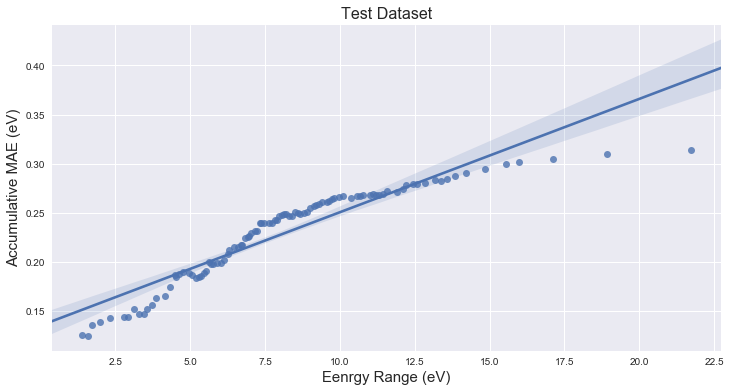

In [10]:
fig, ax = plt.subplots(1, figsize=[12, 6])
sns.regplot(x=np.array(delta_energy), y=np.array(cum_mae), fit_reg=True, ax=ax)
ax.set_xlabel("Eenrgy Range (eV)", fontsize=15)
ax.set_ylabel("Accumulative MAE (eV)", fontsize=15)
ax.set_title("Test Dataset", fontsize=16)

### 2. $\textrm{R}^2$ Score

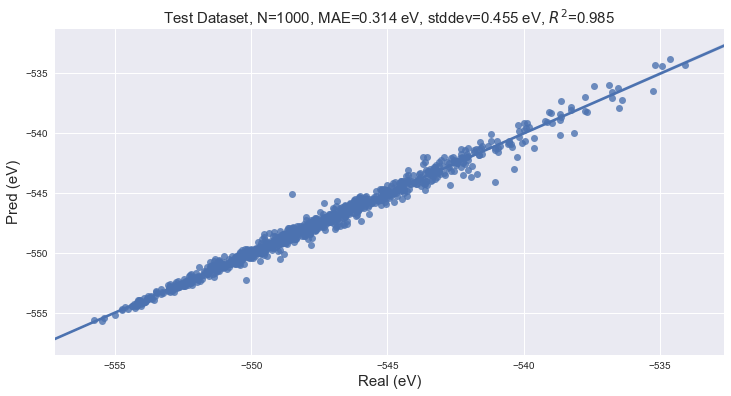

In [11]:
fig, ax = plt.subplots(1, figsize=[12, 6])
sns.regplot(x=y_true, y=y_pred, fit_reg=True, ax=ax)
ax.set_xlabel("Real (eV)", fontsize=15)
ax.set_ylabel("Pred (eV)", fontsize=15)
ax.set_title("Test Dataset, N=1000, MAE=%.3f eV, stddev=%.3f eV, $R^2$=%.3f" % (mae, stddev, score), fontsize=15)

### 3. The Energy Distribution of this Dataset

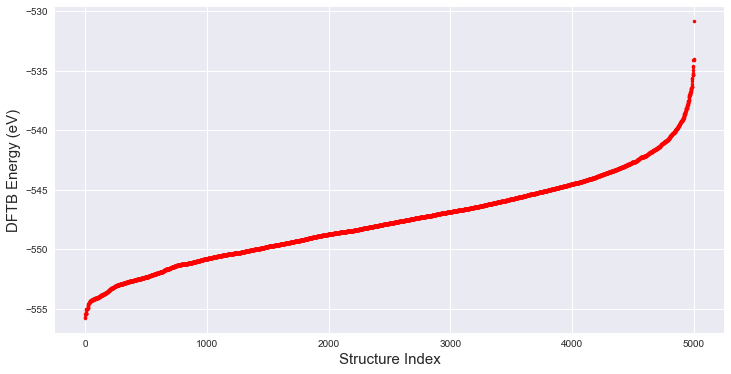

In [12]:
fig, ax = plt.subplots(1, figsize=[12, 6])
ax.plot(energies, "r.")
ax.set_xlabel("Structure Index", fontsize=15)
ax.set_ylabel("DFTB Energy (eV)", fontsize=15)
plt.show()

### 4. Accumulative MAE of the entire dataset.

In [13]:
num_examples = 5000
step = 100
cum_mae = []
delta_energy = []
tic = time.time()
y_total, _, _ = calculator.predict(species, coords)
elapsed = time.time() - tic

for i in range(step, num_examples + 1, step):
  cum_mae.append(np.mean(np.abs(energies[:i] - y_total[:i])))
  delta_energy.append(energies[:i][-1] - energies[0])

print("")
print("Total time used   : %.3f seconds" % elapsed)
print("Average speed     : %.3f examples / second" % (num_examples / elapsed))


Total time used   : 20.389 seconds
Average speed     : 245.236 examples / second


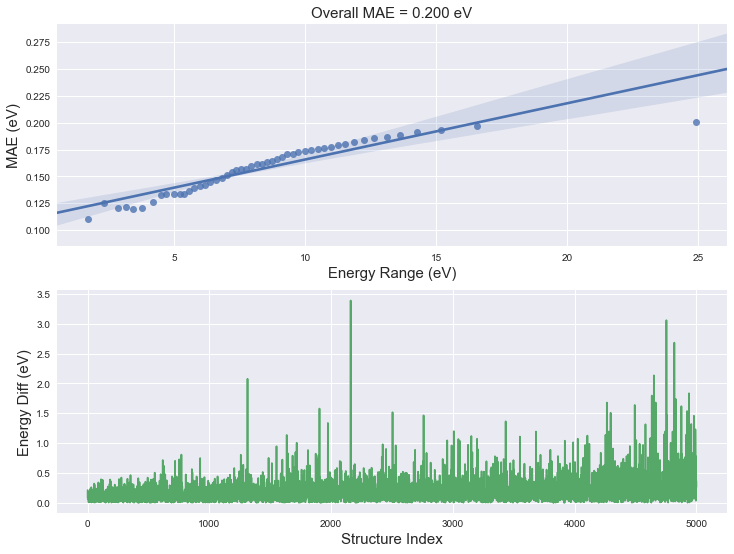

In [14]:
fig, axes = plt.subplots(2, figsize=[12, 9])

ax = axes[0]
sns.regplot(x=np.array(delta_energy), y=np.array(cum_mae), fit_reg=True, ax=ax)
ax.set_xlabel("Energy Range (eV)", fontsize=15)
ax.set_ylabel("MAE (eV)", fontsize=15)
ax.set_title("Overall MAE = %.3f eV" % cum_mae[-1], fontsize=15)

ax = axes[1]
ax.plot(np.abs(y_total - energies))
ax.set_xlabel("Structure Index", fontsize=15)
ax.set_ylabel("Energy Diff (eV)", fontsize=15)

### 5. Find Spikes

There are several sharp spikes in the figure of `Energy Diff / Structure Index`. We shall look into these structures.

In [15]:
diff = np.abs(y_total - energies)
spikes = np.where(diff > 1.5)[0]
print(spikes.tolist())

[1313, 1904, 2160, 2504, 4264, 4295, 4493, 4633, 4650, 4665, 4753, 4818, 4830, 4876, 4923, 4939]


## 3. Cross Tests

C9H7Nv0 is a dataset with 5000 different C9H7N structures. Part of the structures are contained in `C9H7Nv1`. Let's check the performance of our model.

In [16]:
xyzfile = join("..", "datasets", "C9H7N.xyz")
species, energies, coords, _ = extract_xyz(
  xyzfile, 
  xyz_format='grendel', 
  parse_forces=False, 
  num_examples=5000, 
  num_atoms=17
)
energies = np.atleast_1d(energies)

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 1.075 s



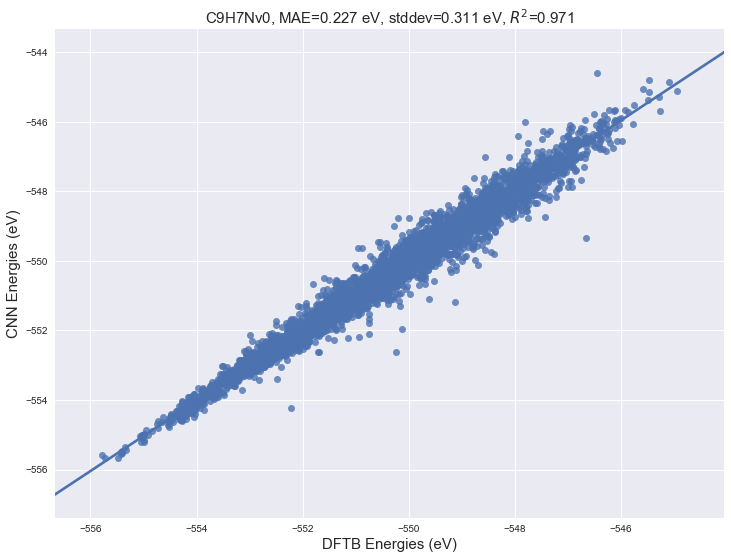

In [17]:
y_total, _, _ = calculator.predict(species, coords)
mae = np.mean(np.abs(energies - y_total))
score = r2_score(energies, y_total)
stddev = np.std(y_total - energies)

fig, ax = plt.subplots(1, figsize=[12, 9])
sns.regplot(x=energies, y=y_total)
ax.set_title("C9H7Nv0, MAE=%.3f eV, stddev=%.3f eV, $R^2$=%.3f" % (mae, stddev, score), fontsize=15)
ax.set_xlabel("DFTB Energies (eV)", fontsize=15)
ax.set_ylabel("CNN Energies (eV)", fontsize=15)

## 4. Atomic Energies

Load the model trained with PBE energies.

In [18]:
model_path = join("./", "models", "C9H7N.v2.PBE", "model.ckpt-2500000")
calculator = CNNPredictor(["C", "H", "N"], model_path, many_body_k=3, max_occurs={"N": 1})

In [19]:
xyzfile = join("..", "datasets", "C9H7N.PBE.xyz")
species, energies, coords, _ = extract_xyz(
  xyzfile, 
  xyz_format='grendel', 
  parse_forces=False, 
  num_examples=5000, 
  num_atoms=17
)
energies = np.atleast_1d(energies)

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 0.831 s



Set the ground energy for each specie.

In [20]:
y_pred, y_atomic, _ = calculator.predict(species, coords[0])
average = {}
for i in range(y_atomic.shape[1]):
  specie = species[i]
  average[specie] = average.get(specie, []) + [y_atomic[0, i]]
for specie, values in average.items():
  avg = np.mean(values)
  average[specie] = avg
  print("Specie {:2s} Average Energy {:7.3f} eV".format(specie, avg))

Specie N  Average Energy  -5.276 eV
Specie C  Average Energy  -9.081 eV
Specie H  Average Energy  -3.454 eV


Define a helper function for computing the atomic energy differences.

In [21]:
def get_energy_diff(y_atomic):
  return np.array([y_atomic[i] - average[species[i]] for i in range(len(species))])

Print the results.

In [22]:
y_pred, y_atomic, _ = calculator.predict(species, coords[:500])
y_true = energies[:500]

for i in range(0, 50, 10):
  print("Index: %4d" % i)
  print("Predicted Energy (eV)     : %8.3f" % y_pred[i])
  print("DFT (PBE) Energy (eV)     : %8.3f" % y_true[i])
  print("DFT (PBE) Rel Energy (eV) : %8.3f" % (y_true[i] - energies[0]))
  print("Absolute Error (eV)       : %8.3f" % np.abs(y_pred[i] - y_true[i]))
  for j in range(17):
    ediff = y_atomic[i, j] - average[species[j]]
    print("  Atom {:2s} Label {:2d} Energy {:8.3f} (eV) {: 12.6f} {: 12.6f} {: 12.6f}".format(
      species[j], j + 1, ediff, *coords[i, j]))
  print("")

Index:    0
Predicted Energy (eV)     : -111.188
DFT (PBE) Energy (eV)     : -111.346
DFT (PBE) Rel Energy (eV) :    0.000
Absolute Error (eV)       :    0.158
  Atom N  Label  1 Energy   -0.000 (eV)    12.473226    12.203464     5.000000
  Atom C  Label  2 Energy   -0.146 (eV)    16.493351    10.925276     5.000000
  Atom C  Label  3 Energy   -0.216 (eV)    15.417834     9.986772     5.000000
  Atom C  Label  4 Energy    0.026 (eV)    16.233803    12.291225     5.000000
  Atom C  Label  5 Energy    0.019 (eV)    14.888811    12.773558     5.000000
  Atom C  Label  6 Energy   -0.144 (eV)    14.557056    14.162553     5.000000
  Atom C  Label  7 Energy    0.051 (eV)    12.222134    13.514515     5.000000
  Atom C  Label  8 Energy   -0.033 (eV)    13.219750    14.536758     5.000000
  Atom C  Label  9 Energy    0.273 (eV)    13.797788    11.823935     5.000000
  Atom C  Label 10 Energy    0.171 (eV)    14.098781    10.426446     5.000000
  Atom H  Label 11 Energy   -0.065 (eV)    17.5382

## 5. Heatmap

Visualize the atomic energies using heatmaps

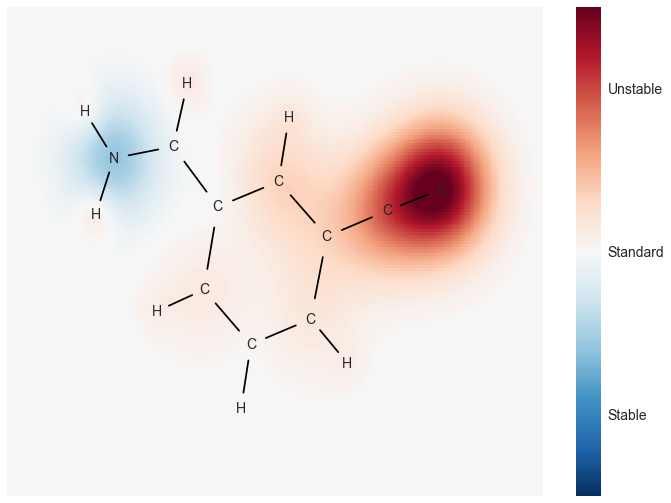

In [29]:
fig, ax = plt.subplots(1, figsize=[12, 9])
index = 29
coordinates = coords[index]
ediff = get_energy_diff(y_atomic[index])
pcolor = kbody_visualize.atomic_heatmap2d(species, coordinates, ediff, ax)
kbody_visualize.colorbar(fig, ax, pcolor, label_values=False)